In [1]:
!pip install keras-cv
!pip install gdown

### Defining learning stratagy

In [2]:
import tensorflow as tf
print(tf.__version__)

cur_dir = %env PWD
is_kaggle = cur_dir == '/kaggle/working'
try:
    tpu = 'local' if is_kaggle else ''    
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print('Using TPU')
    # print("TPU devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.TPUStrategy(resolver)
except:
    GPU_list = tf.config.list_physical_devices('GPU')
    GPU_count = len(GPU_list) if type(GPU_list) is list else 0
    if GPU_count == 0:
        print('Using CPU')
        strategy = tf.distribute.get_strategy()
    else:
        print('Using GPU')
        # print("GPU devices: ", tf.config.list_logical_devices('GPU'))
        if len(GPU_list) == 1:
            strategy = tf.distribute.get_strategy()
        else:
            # strategy = tf.distribute.MirroredStrategy() # Швидше, але використовує більше пам'яті GPU
            strategy = tf.distribute.experimental.CentralStorageStrategy()

print('DEVICES AVAILABLE:', strategy.num_replicas_in_sync)

2024-10-15 19:08:05.466620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 19:08:05.466736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 19:08:05.602412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
Using GPU
DEVICES AVAILABLE: 1


In [3]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

#import keras
import keras_cv
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display, Image
import pandas as pd
from tensorflow.keras import mixed_precision

# print('GPU:', tf.config.list_physical_devices('GPU'))

Using TensorFlow backend


Set the mode of mixed precision

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Loading dataset

In [5]:
X_TRAIN_DIR = "/kaggle/input/bdd-remade/train_images"
Y_TRAIN_DIR = "/kaggle/input/bdd-remade/train_masks"
X_VAL_DIR = "/kaggle/input/bdd-remade/val_images"
Y_VAL_DIR = "/kaggle/input/bdd-remade/val_masks"

In [6]:
IMAGE_SIZE_X = 640
IMAGE_SIZE_Y = 384
NUM_CLASSES = 2
seed = 42
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 12 * strategy.num_replicas_in_sync

In [7]:
BATCH_SIZE

12

In [8]:
train_ds_x = tf.keras.utils.image_dataset_from_directory(
    X_TRAIN_DIR,
    labels=None ,
    color_mode='rgb',
    batch_size=None,
    image_size=(IMAGE_SIZE_Y, IMAGE_SIZE_X),
    shuffle=False,
    seed=seed,
    interpolation='nearest',
)
train_ds_y = tf.keras.utils.image_dataset_from_directory(
    Y_TRAIN_DIR,
    labels=None ,
    color_mode='grayscale',
    batch_size=None,
    image_size=(IMAGE_SIZE_Y, IMAGE_SIZE_X),
    shuffle=False,
    seed=seed,
    interpolation='nearest',
)
orig_train_ds = tf.data.Dataset.zip(train_ds_x, train_ds_y)

Found 70000 files belonging to 1 classes.
Found 70000 files belonging to 1 classes.


In [9]:
val_ds_x = tf.keras.utils.image_dataset_from_directory(
    X_VAL_DIR,
    labels=None ,
    color_mode='rgb',
    batch_size=None,
    image_size=(IMAGE_SIZE_Y, IMAGE_SIZE_X),
    shuffle=False,
    seed=seed,
    interpolation='nearest',
)
val_ds_y = tf.keras.utils.image_dataset_from_directory(
    Y_VAL_DIR,
    labels=None ,
    color_mode='grayscale',
    batch_size=None,
    image_size=(IMAGE_SIZE_Y, IMAGE_SIZE_X),
    shuffle=False,
    seed=seed,
    interpolation='nearest',
)
orig_val_ds = tf.data.Dataset.zip(val_ds_x.take(1000), val_ds_y.take(1000))
orig_test_ds = tf.data.Dataset.zip(val_ds_x.skip(1000), val_ds_y.skip(1000))                                                    

Found 10000 files belonging to 1 classes.
Found 10000 files belonging to 1 classes.


In [26]:
inf_ds = orig_test_ds.take(10)

In [27]:
inf_img = val_ds_x.take(10)

### Rescale images and correct masks

In [10]:
rescale_images_and_correct_masks = lambda image, mask: {
    "images": tf.cast(image, dtype=tf.float32) / 255.0,
    "segmentation_masks": tf.cast(tf.where(mask > 0, tf.constant(255, dtype=tf.uint8), mask), dtype=tf.float32) / 255,
}

train_ds = orig_train_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)
test_ds = orig_test_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

In [11]:
train_ds

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(384, 640, 3), dtype=tf.float32, name=None), 'segmentation_masks': TensorSpec(shape=(384, 640, 1), dtype=tf.float32, name=None)}>

In [12]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

## Data preprocess and augmentation

In [13]:
ROTATION_FACTOR = (-0.05, 0.05)
preprocess_fn = keras.Sequential(
    [
        keras_cv.layers.AutoContrast([0,1]),
#         keras_cv.layers.Posterization([0,1],bits=6),
    ]
)

augment_fn = keras.Sequential(
    [
        keras_cv.layers.AutoContrast([0,1]),
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomRotation(factor=ROTATION_FACTOR,
                                       segmentation_classes=NUM_CLASSES),
#         keras_cv.layers.RandomSharpness(factor=0.5, value_range=[0,1], seed=seed),
#         keras_cv.layers.GridMask(ratio_factor=(0, 0.5),rotation_factor=0.15, seed=seed),
#         keras_cv.layers.RandomZoom(height_factor=(-0.3,-0.5),width_factor=(-0.2,-0.4),seed=seed),
    ]
)

In [14]:
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 3)
    .map(augment_fn,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
resized_val_ds = (
    val_ds.map(preprocess_fn,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
resized_test_ds = (
    test_ds.map(preprocess_fn,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

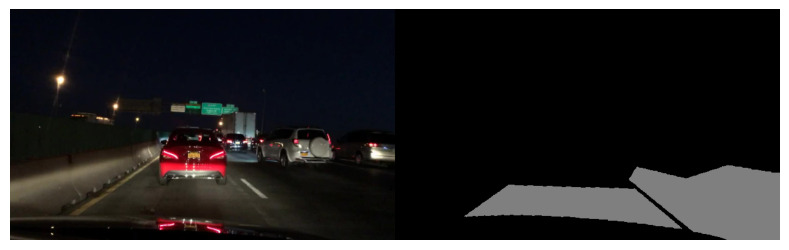

In [15]:
images, segmentation_masks = next(iter(augmented_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
   images,
   value_range=(0, 1),
   num_classes=2,
   y_true=segmentation_masks,
   scale=8,
   rows=1,
   cols=1,
)

## Loading model and weights

In [16]:
with strategy.scope():
    model = keras_cv.models.DeepLabV3Plus.from_preset(
        "yolo_v8_m_backbone_coco", load_weights=False,
        num_classes=NUM_CLASSES, input_shape=[IMAGE_SIZE_Y, IMAGE_SIZE_X, 3]
    )
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=0.001),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False)],
        #jit_compile=False
    )

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_m_backbone_coco/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_m_backbone_coco/2' to your Kaggle notebook...


In [16]:
#!gdown 1sW2OVQF2xCWX6BkoM_8oNYvnV2oBm-jv

Downloading...
From (original): https://drive.google.com/uc?id=1sW2OVQF2xCWX6BkoM_8oNYvnV2oBm-jv
From (redirected): https://drive.google.com/uc?id=1sW2OVQF2xCWX6BkoM_8oNYvnV2oBm-jv&confirm=t&uuid=5b30c8e2-c33a-4dae-96e2-fa80dedb5898
To: /kaggle/working/model_yolo_5.keras
100%|████████████████████████████████████████| 332M/332M [00:04<00:00, 72.6MB/s]


In [ ]:
model.load_weights('/kaggle/working/model_mobile_04-0.08.hdf5')

### Callbacks

In [16]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_mean_io_u', patience=4, restore_best_weights=True)

In [17]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model_{epoch:02d}-{val_loss:.2f}.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [ ]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

In [18]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [17]:
!gdown 1wkdjlCiaoW_IeobffnPZg-hYy2EMgERZ

Downloading...
From (original): https://drive.google.com/uc?id=1wkdjlCiaoW_IeobffnPZg-hYy2EMgERZ
From (redirected): https://drive.google.com/uc?id=1wkdjlCiaoW_IeobffnPZg-hYy2EMgERZ&confirm=t&uuid=931ab07a-0606-40a5-87c1-d4123472206f
To: /kaggle/working/model.keras
100%|████████████████████████████████████████| 604M/604M [00:09<00:00, 62.9MB/s]


In [19]:
with strategy.scope():
    model = keras.saving.load_model("/kaggle/working/model.keras")

/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


## Model summary

In [21]:
model.summary()

Model: "deep_lab_v3_plus_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_1 (Functional)        {'P2': (None, None, None,    2033136   ['input_2[0][0]']             
                             48),                         0                                       
                              'P5': (None, None, None,                                            
                             1280)}                                                               
                                                                                                  
 spatial_pyramid_pooling (S  (None, None, None, 256)      9836544   ['model_1[0][

In [ ]:
model.compile(
#     optimizer=keras.optimizers.AdamW(learning_rate=0.00001, weight_decay=0.006),
    optimizer=keras.optimizers.AdamW(learning_rate=0.00001,weight_decay=0.005),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False)],
)

## Training

In [ ]:
history = model.fit(augmented_train_ds,
                    validation_data=resized_val_ds,
                    epochs=1,
                    # callbacks=[csv_logger, EarlyStop, checkpoint],
                    callbacks=[EarlyStop, reduce_lr, checkpoint],
                    )

In [ ]:
!pip install lcurvetools
from lcurvetools import history_concatenate, lcurves_by_history

In [ ]:
lcurves_by_history(history.history);

In [ ]:
df = pd.DataFrame(history.history)
df

In [ ]:
df.to_csv('history_mobile_5.csv', index=False,sep=';')

In [ ]:
model.save("model_mobile_5.keras")

## Evaluation

In [ ]:
scores = model.evaluate(resized_test_ds)

In [40]:
test_images, test_masks = next(iter(resized_test_ds.take(3)))

In [41]:
pred_masks = model.predict(test_images)
pred_masks = tf.math.argmax(pred_masks, axis=-1)[..., None]

1/1 [==============================] - 0s 52ms/step


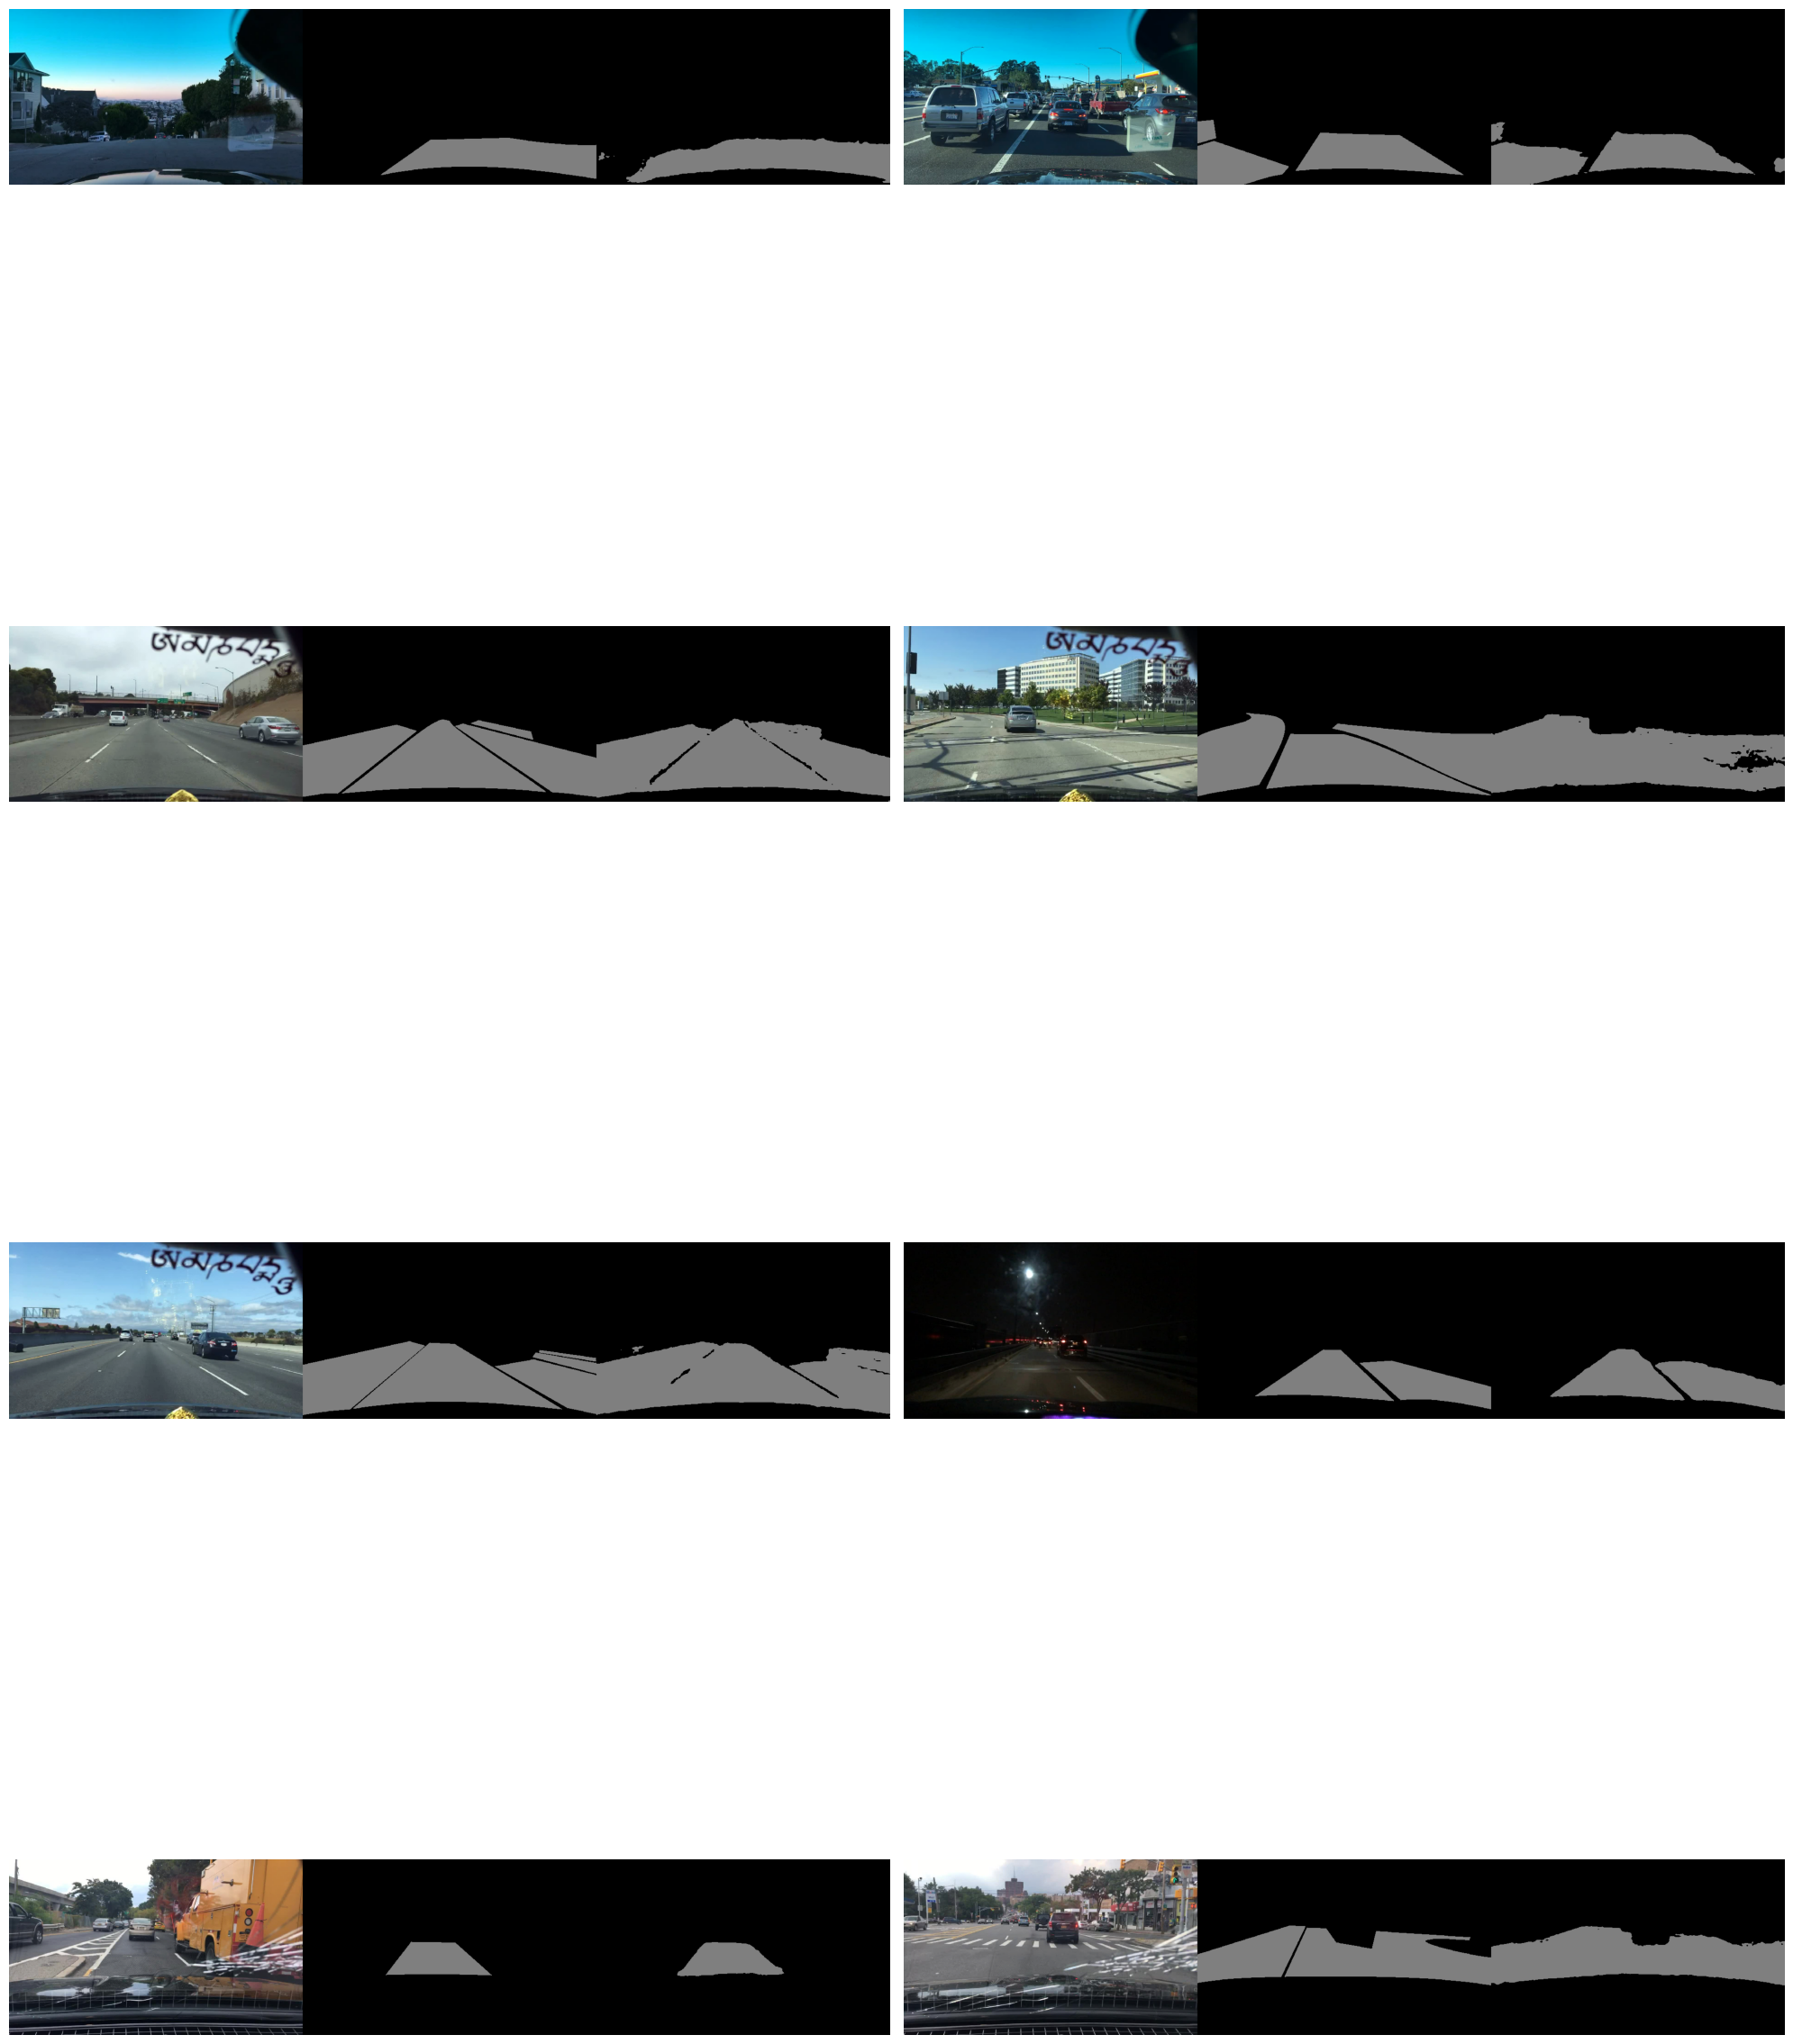

In [71]:
keras_cv.visualization.plot_segmentation_mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=2,
    y_true=test_masks,
    y_pred=pred_masks,
    scale=10,
    rows=4,
    cols=2,
)

## Evalualuation on independent data

In [25]:
!gdown 1sXf7jv60wdyHfEBLAE4ykMeCmKjg3ws7
!unzip -q /kaggle/working/real_img.zip

Downloading...
From: https://drive.google.com/uc?id=1sXf7jv60wdyHfEBLAE4ykMeCmKjg3ws7
To: /kaggle/working/real_img.zip
100%|██████████████████████████████████████| 25.5M/25.5M [00:00<00:00, 41.5MB/s]


In [26]:
REAL_IMG = "/kaggle/working/real_img"

In [27]:
BATCH_SIZE_REAL = 3
real_img_ds_full = tf.keras.utils.image_dataset_from_directory(
    REAL_IMG,
    labels=None ,
    color_mode='rgb',
    batch_size=None,
    image_size=(IMAGE_SIZE_Y, IMAGE_SIZE_X),
    shuffle=True,
    seed=seed,
    interpolation='nearest',
)

Found 21 files belonging to 1 classes.


In [89]:
BATCH_SIZE_REAL = 5

In [ ]:
rescale_images = lambda image: {
    "images": tf.cast(image, dtype=tf.float32) / 255.0,
}
real_img_ds_norm = inf_ds.map(rescale_images, num_parallel_calls=AUTOTUNE)

def unpackage_real_inputs(inputs):
    images = inputs["images"]
    return images

In [22]:
from keras.preprocessing import image
from keras.utils import array_to_img
def create_binary_colormap():
    colormap = np.zeros((2, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]  # color (black)
    colormap[1] = [0, 255, 0]  # color (white)
    return colormap

def infer(model, image_tensor):
    predictions = model.predict(image_tensor)
    predictions = np.squeeze(predictions)

    # Apply threshold
    driving_area_predictions = predictions[:, :, 1]  # Assuming the driving area is class 1
    driving_area_predictions[driving_area_predictions < 0.4] = 0
    driving_area_predictions[driving_area_predictions >= 0.4] = 1

    return driving_area_predictions

def decode_segmentation_masks(mask, colormap):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, len(colormap)):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    return overlay

def plot_samples_matplotlib(display_list, figsize=(5, 3), n_images=None):
    n_rows = 3 if n_images is None else n_images
    n_cols = len(display_list) // n_rows
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i in range(len(display_list)):
        ax = axes[i // n_cols, i % n_cols]
        if display_list[i].shape[-1] == 3:
            ax.imshow(array_to_img(display_list[i]))
        else:
            ax.imshow(display_list[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_predictions(dataset, model):
    colormap = create_binary_colormap()
    for batch in dataset.take(1): 
        n_images = len(batch)
        display_list = []
        for i in range(n_images):
            image = batch[i]
            prediction_mask = infer(model, np.expand_dims(image, axis=0))
            prediction_colormap = decode_segmentation_masks(prediction_mask, colormap)
            overlay = get_overlay(image, prediction_colormap)
            display_list.extend([image, overlay, prediction_colormap])

        plot_samples_matplotlib(display_list, figsize=(18, 14), n_images=n_images)

In [87]:
def plot_predictions_ground(dataset, model):
    colormap = create_binary_colormap()
    for batch in dataset.take(1): 
        display_list = []
        image_batch = batch[0]
        mask_batch = batch[1]
        n_images = len(image_batch)
        for i in range(n_images):
            image = image_batch[i]
            mask = mask_batch[i]
            prediction_mask = infer(model, np.expand_dims(image, axis=0))
            prediction_colormap = decode_segmentation_masks(prediction_mask, colormap)
            overlay = get_overlay(image, prediction_colormap)
            ground_truth = np.squeeze(decode_segmentation_masks(mask, colormap),axis=-1)
            true_overlay = get_overlay(image, ground_truth)
            display_list.extend([image, true_overlay, overlay])

        plot_samples_matplotlib(display_list, figsize=(18, 14), n_images=n_images)

In [59]:
inf_ds_norm = inf_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

In [102]:
resized_inf_ds = (
    inf_ds_norm.shuffle(BATCH_SIZE * 3)
    .map(preprocess_fn,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE_REAL)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [92]:
real_img_ds = (
    inf_img_norm.map(preprocess_fn,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE_REAL)
    .map(unpackage_real_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

1/1 [==============================] - 0s 36ms/step


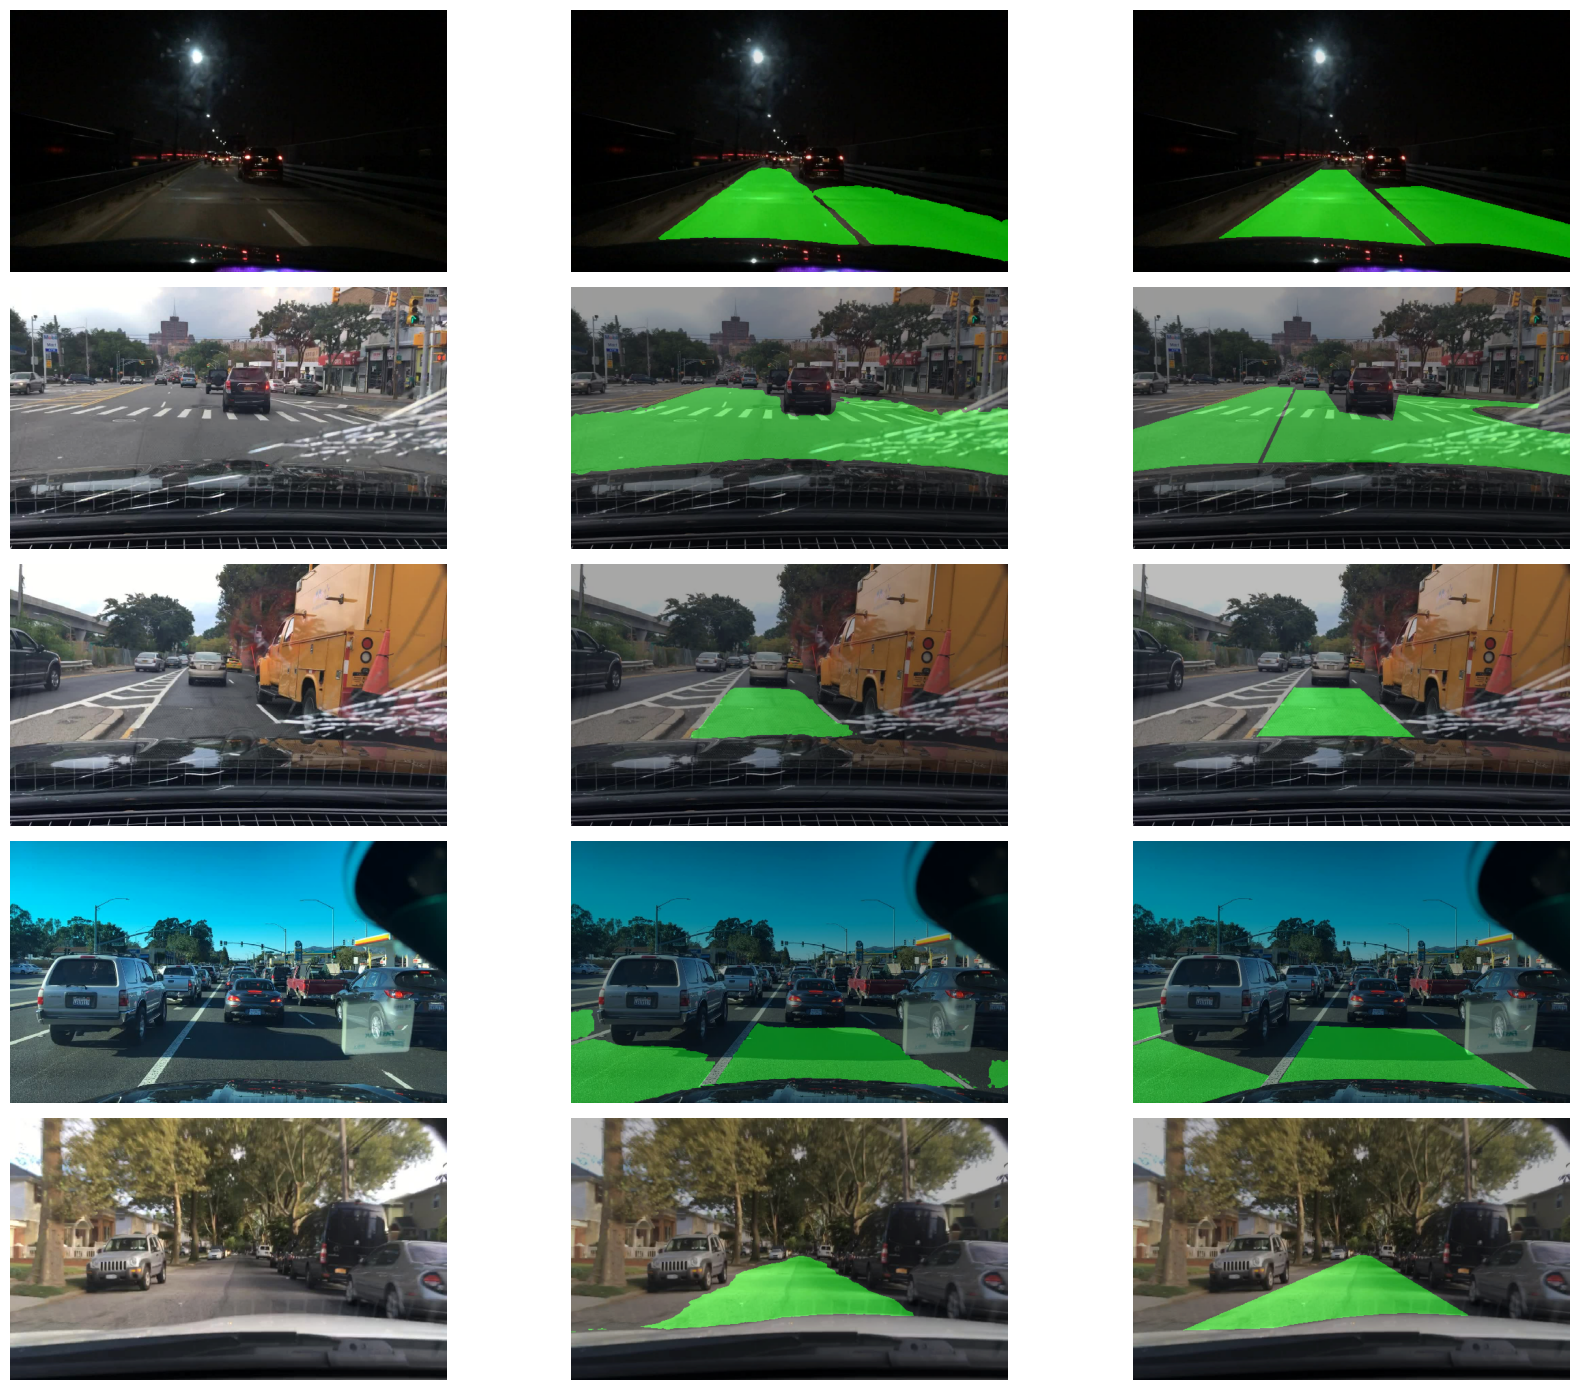

In [103]:
plot_predictions_ground(resized_inf_ds, model)